In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 32.7 MB/s eta 0:00:00


In [5]:
import tensorflow as tf
import os
import shutil
import pickle
from google.colab import files 
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D  
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import tensorflow_addons as tfa
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation
from keras.callbacks import ReduceLROnPlateau
from datetime import datetime
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from PIL import Image
import cv2
from tensorflow.keras.applications import ResNet50
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

from skimage import io
from skimage.transform import resize

## Init Program

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip Data

In [4]:
! unzip '/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Datasets/Corn/Train.zip' -d . 

Streaming output truncated to the last 5000 lines.
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(1900).jpg  
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(1901).jpg  
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(1902).jpg  
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(1903).JPG  
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(1904).JPG  
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(1905).JPG  
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(1906).JPG  
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(1907).JPG  
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(1908).JPG  
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(1909).JPG  
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(191).JPG  
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(1910).JPG  
  inflating: ./train/Corn Gray leaf spot/CornGrayLeafSpot(1911).JPG  
  inflating: ./train/Corn Gray leaf spot

In [ ]:
os.listdir('/content/drive/Shareddrives/Teman Tani/Capstone 2023')

['Teman Tani Bangkit 2023 Product-based Capstone.gdoc',
 'Machine Learning',
 'Teman Tani Schedule.gsheet',
 'Mobile']

### Supporting Function

In [6]:
from tensorflow.keras.callbacks import Callback

class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.95:
            print("Validation accuracy reached 0.95 or higher. Stopping training.")
            self.model.stop_training = True

In [7]:
def callbacks(filename):
  es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.3,
                          patience = 3,
                          min_lr = 1e-6,
                          mode = 'min',
                          verbose = 1)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  stop_training_callback = StopTrainingCallback()

  return [es, mc, reduce_lr, stop_training_callback]

In [8]:
def predict_new_data(model, shape, path):
  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())

  img = load_img(path, target_size=shape)
  imgplot = plt.imshow(img)
  target = img_to_array(img)
  target = np.expand_dims(target, axis=0)
  target = np.vstack([target])
  target /= 255
  pred = model.predict(target)
  return labels[np.argmax(pred, axis=1)[0]]

In [9]:
def save_model(name, model, model_dir):
  path = os.path.join(model_dir, name)
  if os.path.isdir(path):
    print('\nReplacing the model with the new One\n')
    shutil.rmtree(path, ignore_errors=True)

  model.save(path)
  print("Export path: ", path)
  print(os.listdir(path))

### Prepare Data

In [28]:
image_shape=255
datagen = ImageDataGenerator(
       rotation_range=40, 
            width_shift_range=0.15,
            height_shift_range=0.15, 
            zoom_range=0.1, 
            rescale=1.0/255,
            horizontal_flip=True, 
            vertical_flip=True, 
            brightness_range=[0.75,1.25], 
            validation_split=0.2
)

val_datagen=ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)
batch_size = 75 #Bisa diganti2

train_generator = datagen.flow_from_directory(
    '/content/train',
    target_size =(255,255),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training',
    
)

validation_generator = val_datagen.flow_from_directory(
    '/content/train',
    target_size = (255,255),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='validation',
    shuffle=False
)

Found 6400 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.


In [29]:
train_generator.class_indices

{'Corn Common rust': 0,
 'Corn Gray leaf spot': 1,
 'Corn Healthy': 2,
 'Corn Northern Leaf Blight': 3}

## Modelling

In [30]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

### Model 1 (DenseNet121) 0.95 VAL ACC

In [31]:
model1 = Sequential()
model1.add(tf.keras.applications.DenseNet121(input_shape = (255, 255, 3), include_top = False, weights = 'imagenet' ))
model1.add(Dropout(0.4))
model1.add(GlobalAveragePooling2D())
model1.add(Dense(512, activation = 'relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model1.add(Dropout(0.4))
model1.add(Dense(4, activation = 'softmax'))

In [32]:
model1.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 2e-4),
              metrics=['accuracy'])

In [33]:
 history = model1.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 30,
                             batch_size = 64,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=callbacks("Model_DenseNet121.h5")
                            )

Epoch 1/30
85/85 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9222
Epoch 1: val_accuracy improved from -inf to 0.92571, saving model to Model_DenseNet121.h5
85/85 [==============================] - 252s 2s/step - loss: 0.2104 - accuracy: 0.9222 - val_loss: 0.2279 - val_accuracy: 0.9257 - lr: 2.0000e-04
Epoch 2/30
85/85 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9722
Epoch 2: val_accuracy improved from 0.92571 to 0.95683, saving model to Model_DenseNet121.h5
Validation accuracy reached 0.95 or higher. Stopping training.
85/85 [==============================] - 173s 2s/step - loss: 0.0873 - accuracy: 0.9722 - val_loss: 0.1559 - val_accuracy: 0.9568 - lr: 2.0000e-04


In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [35]:
label_types = []
for category in train_generator.class_indices:
  label_types.append(category)
label_types

['Corn Common rust',
 'Corn Gray leaf spot',
 'Corn Healthy',
 'Corn Northern Leaf Blight']

In [36]:
y_test = validation_generator.classes
y_pred = model1.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

<ipython-input-36-1f97d7f25348>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model1.predict_generator(validation_generator)


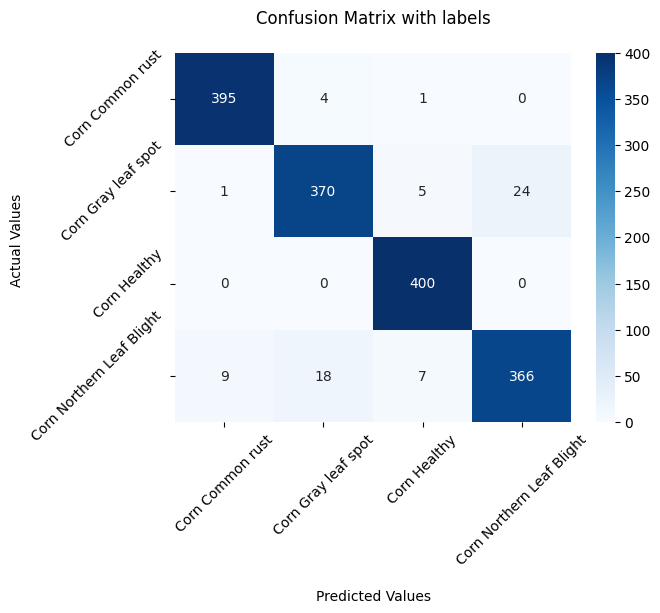

In [37]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(label_types, rotation=45)
ax.yaxis.set_ticklabels(label_types, rotation=45)

plt.show()

In [ ]:
def normalize_image(image):
    height, width, _ = image.shape
    norm_size = max(height, width)
    add_h = norm_size - height
    add_w = norm_size - width
    start_add_h = add_h // 2
    start_add_w = add_w // 2
    new_img = np.full((norm_size, norm_size, 3), 255, dtype=np.uint8)
    new_img[start_add_h:start_add_h + height, start_add_w:start_add_w + width, :] = image
    return new_img

def preprocessing(image):
  img = normalize_image(image)
  img = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA)
  return np.array(img)

1/1 [==============================] - 0s 127ms/step


'Corn Gray leaf spot'

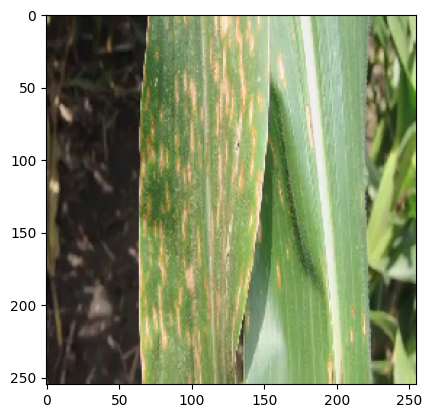

In [49]:
predict_new_data(new_model, (255,255), '/content/maxresdefault.jpg')

In [44]:
save_model("Densenet121-0.95val", new_model, "/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Corn/Model")

Export path:  /content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Corn/Model/Densenet121-0.95val
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']


In [42]:
new_model = tf.keras.models.load_model('/content/Model_DenseNet121.h5')

### Model 2 (MobileNetV2 0.72 Acc) Not Corn

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 

In [ ]:
model2 = tf.keras.models.Sequential([
    MobileNetV2(weights="imagenet", include_top=False, input_shape=(image_shape,image_shape,3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  
])

model2.layers[0].trainable = False

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 512)               655872    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dense_10 (Dense)            (None, 5)                

In [ ]:
model2.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 2e-4),
              metrics=['accuracy'])

In [ ]:
 history2 = model2.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 30,
                             batch_size = 64,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=callbacks("Model_MobileNetV2.h5")
                            )

Epoch 1/30
53/53 [==============================] - ETA: 0s - loss: 1.3024 - accuracy: 0.4701
Epoch 1: val_accuracy improved from -inf to 0.59385, saving model to Model_MobileNetV2.h5
53/53 [==============================] - 98s 2s/step - loss: 1.3024 - accuracy: 0.4701 - val_loss: 1.0468 - val_accuracy: 0.5938 - lr: 2.0000e-04
Epoch 2/30
53/53 [==============================] - ETA: 0s - loss: 1.0289 - accuracy: 0.6117
Epoch 2: val_accuracy improved from 0.59385 to 0.65436, saving model to Model_MobileNetV2.h5
53/53 [==============================] - 92s 2s/step - loss: 1.0289 - accuracy: 0.6117 - val_loss: 0.9299 - val_accuracy: 0.6544 - lr: 2.0000e-04
Epoch 3/30
53/53 [==============================] - ETA: 0s - loss: 0.9624 - accuracy: 0.6322
Epoch 3: val_accuracy improved from 0.65436 to 0.66359, saving model to Model_MobileNetV2.h5
53/53 [==============================] - 91s 2s/step - loss: 0.9624 - accuracy: 0.6322 - val_loss: 0.9091 - val_accuracy: 0.6636 - lr: 2.0000e-04
Epoc

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
label_types = list(train_generator.class_indices.keys())
label_types

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

In [ ]:
y_test = validation_generator.classes
y_pred = model2.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

<ipython-input-34-b6fc1ad3b738>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model2.predict_generator(validation_generator)


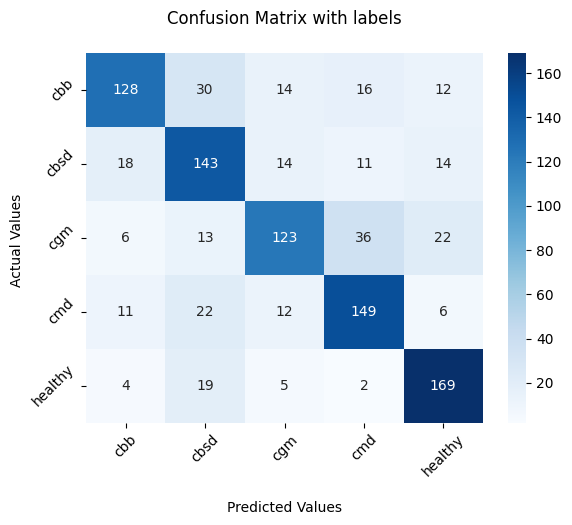

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(label_types, rotation=45)
ax.yaxis.set_ticklabels(label_types, rotation=45)

plt.show()

In [ ]:
def normalize_image(image):
    height, width, _ = image.shape
    norm_size = max(height, width)
    add_h = norm_size - height
    add_w = norm_size - width
    start_add_h = add_h // 2
    start_add_w = add_w // 2
    new_img = np.full((norm_size, norm_size, 3), 255, dtype=np.uint8)
    new_img[start_add_h:start_add_h + height, start_add_w:start_add_w + width, :] = image
    return new_img

def preprocessing(image):
  img = normalize_image(image)
  img = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA)
  return np.array(img)
     

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [ ]:
img = io.imread("/content/train-cgm-646.jpg")

In [ ]:
img = preprocessing(img)
resized_image = resize(img, (255, 255), anti_aliasing=True)

In [ ]:
input_images = np.reshape(resized_image, (-1, 255, 255, 3))

In [ ]:
preds = new_model.predict(input_images)
labels[np.argmax(preds, axis=1)[0]]

1/1 [==============================] - 0s 67ms/step


'cgm'

In [ ]:
save_model("MobileNetV2-0.72val", model2, "/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Cassava/Model")

Export path:  /content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Cassava/Model/MobileNetV2-0.72val
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Cassava/Model/Densenet121-0.81val')

### Model 3 Not Corn

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB1

In [ ]:
model3 = tf.keras.models.Sequential([
    EfficientNetB1(weights="imagenet", include_top=False, input_shape=(image_shape,image_shape,3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5, activation='softmax')  
])

model3.layers[0].trainable = False

model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 8, 1280)       6575239   
                                                                 
 global_average_pooling2d_11  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_29 (Dense)            (None, 512)               655872    
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 32)                16416     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                     

In [ ]:
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='auto', save_best_only=False):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.best_value = None

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.monitor)
        if self.best_value is None or self._is_improvement(current_value):
            self.best_value = current_value
            self.model.save_weights(self.filepath, overwrite=True)
            print(f"Saved weights at epoch {epoch+1} with {self.monitor}: {current_value}")

    def _is_improvement(self, current):
        if self.mode == 'auto':
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                return current > self.best_value
            else:
                return current < self.best_value
        elif self.mode == 'min':
            return current < self.best_value
        else:
            return current > self.best_value

def callbacks(filename):
    es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, mode='min', verbose=1)
    mc = CustomModelCheckpoint(filename, monitor='val_accuracy', mode='max', save_best_only=True)

    return [es, mc, reduce_lr]

In [ ]:
model3.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 1e-4),
              metrics=['accuracy'])

In [ ]:
 history3 = model3.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 30,
                             batch_size = 64,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=callbacks("Model_EfficientNetB7.h5")
                            )

Epoch 1/30
53/53 [==============================] - 101s 2s/step - loss: 183.7319 - accuracy: 0.1934 - val_loss: 166.9194 - val_accuracy: 0.2308 - lr: 1.0000e-04
Epoch 2/30
53/53 [==============================] - 94s 2s/step - loss: 151.6556 - accuracy: 0.2064 - val_loss: 136.2472 - val_accuracy: 0.1795 - lr: 1.0000e-04
Epoch 3/30
53/53 [==============================] - 91s 2s/step - loss: 122.5521 - accuracy: 0.1982 - val_loss: 108.7744 - val_accuracy: 0.2051 - lr: 1.0000e-04
Epoch 4/30
53/53 [==============================] - 89s 2s/step - loss: 96.5837 - accuracy: 0.1990 - val_loss: 84.5011 - val_accuracy: 0.2051 - lr: 1.0000e-04
Epoch 5/30
53/53 [==============================] - 90s 2s/step - loss: 73.9384 - accuracy: 0.1985 - val_loss: 63.4122 - val_accuracy: 0.1795 - lr: 1.0000e-04
Epoch 6/30
53/53 [==============================] - 91s 2s/step - loss: 54.4730 - accuracy: 0.1982 - val_loss: 45.5290 - val_accuracy: 0.2051 - lr: 1.0000e-04
Epoch 7/30
53/53 [=====================

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-82-66258cf9f581>", line 1, in <cell line: 1>
    history3 = model3.fit(train_generator,
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_func

TypeError: ignored